In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ks_2samp
from lifelines import KaplanMeierFitter
from lifelines.plotting import add_at_risk_counts
from matplotlib_venn import venn2
from venn import venn

sns.set_palette('colorblind')
sns.set_style('white') 
palette = sns.color_palette('colorblind', 6)

In [15]:
# Create dictionary to map gene ID to gene name
df = pd.read_csv('/Users/tk/Desktop/Research-CITS5014/Raw_gene_count/0a9e33db-2527-4cc3-8669-a7c10fed7a7f.rna_seq.augmented_star_gene_counts.tsv', delimiter='\t', header=1)
df = df.iloc[4:]
gene_id_to_name = dict(zip(df['gene_id'], df['gene_name']))

In [16]:
# Read normalised gene count file
df_with_subtype = pd.read_csv('/Users/tk/Desktop/gene_project/norm_pam50.csv', sep=',', index_col=0)
df_with_subtype.index.name = None

# Get survival time, status, and subtype from the dataframe
survival_time = pd.to_numeric(df_with_subtype.iloc[-3].values, errors='coerce')
status = pd.to_numeric(df_with_subtype.iloc[-2].values, errors='coerce')
subtypes = df_with_subtype.iloc[-1].values

/var/folders/nn/n9lqp7fs1pq402h_v1c984h40000gn/T/ipykernel_3371/3761208136.py:2: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,

In [19]:
gene_list = ['ENSG00000168393.13', 'ENSG00000260924.2', 'ENSG00000237575.4'] # From venn diagram: All subtypes
ks_result = pd.read_csv(f'/Users/tk/Desktop/gene_project/result3/ks_All.csv', sep=',')
jsd_result = pd.read_csv(f'/Users/tk/Desktop/gene_project/result3/jsd_All.csv', sep=',')

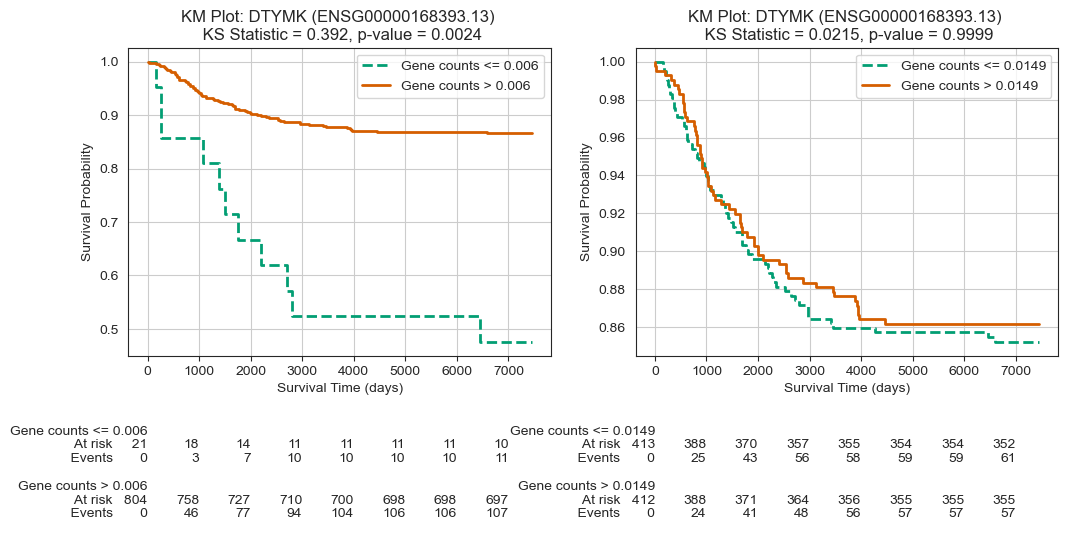

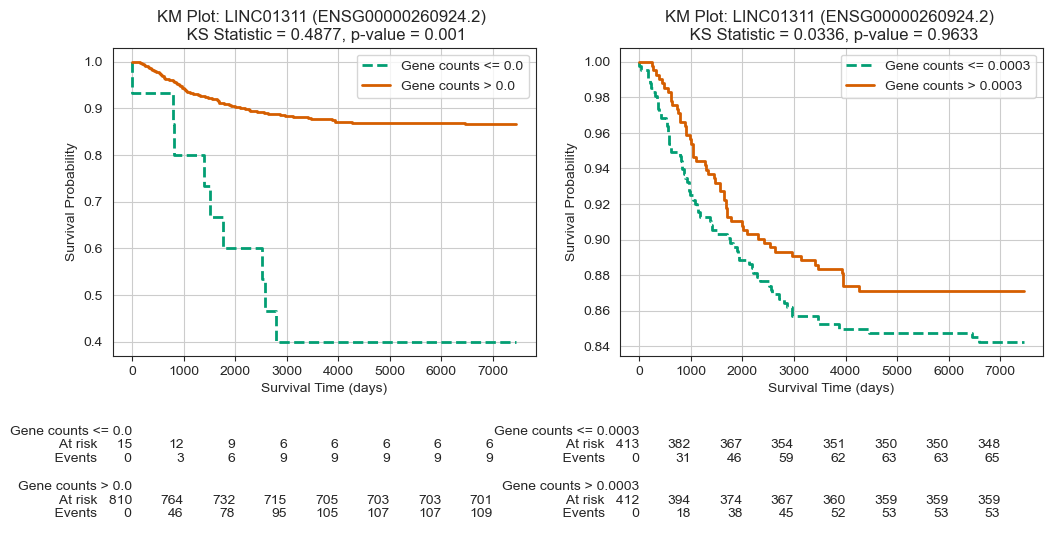

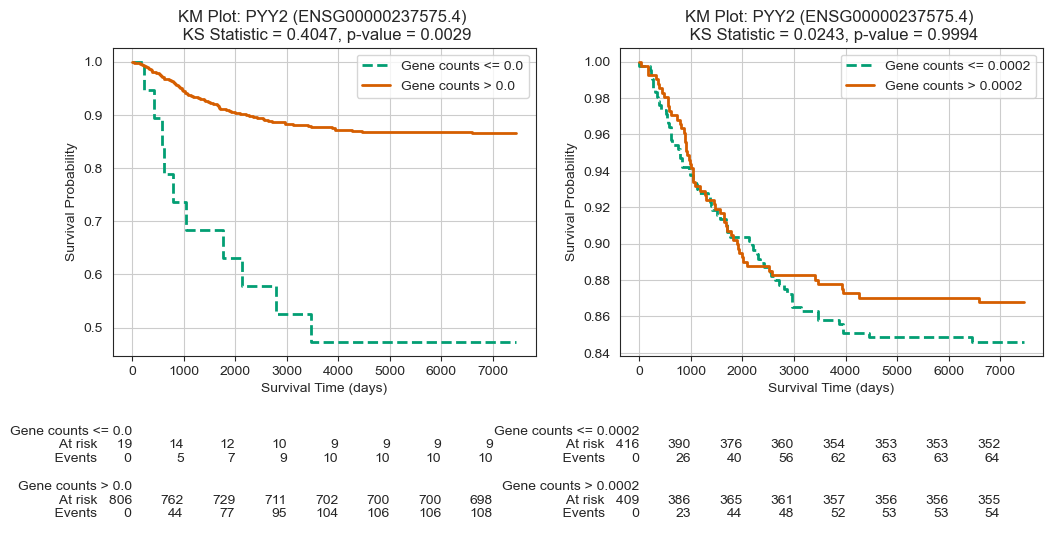

In [25]:
# KM plot using optimal threshold VS median
for i, gene in enumerate(gene_list):

    # Get gene count of that gene
    row = pd.to_numeric(df_with_subtype.loc[gene].values, errors='coerce')

    # Get optimal threshold for that gene
    tbl = ks_result[ks_result['gene'] == gene]
    optimal_threshold = pd.to_numeric(tbl['threshold_All'].values[0], errors='coerce')

    # Extract days to death
    time_g1 = survival_time[row <= optimal_threshold]
    time_g2 = survival_time[row > optimal_threshold]
    
    # Extract status
    status_g1 = status[row <= optimal_threshold]
    status_g2 = status[row > optimal_threshold]

    data_g1 = pd.DataFrame({
        'survival_time': time_g1,
        'group': 'Low Expression',
        'event_occurred': status_g1})

    data_g2 = pd.DataFrame({
        'survival_time': time_g2,
        'group': 'HighExpression',
        'event_occurred': status_g2})

    data = pd.concat([data_g1, data_g2], axis=0, ignore_index=True)

    # Calculate KS statistic
    ks_stat, ks_pval = ks_2samp(time_g1, time_g2)
    text = f"KS Statistic = {round(ks_stat, 4)}, p-value = {round(ks_pval, 4)}"

    # Fit KaplanMeierFitter
    kmf_1 = KaplanMeierFitter()
    kmf_2 = KaplanMeierFitter()
    kmf_1.fit(data_g1['survival_time'], data_g1['event_occurred'], label=f"Gene counts <= {round(optimal_threshold, 4)}")
    kmf_2.fit(data_g2['survival_time'], data_g2['event_occurred'], label=f"Gene counts > {round(optimal_threshold, 4)}")

    # Plot Kaplan-Meier survival functions
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))

    # Top subplot
    ax = axs[0]
    kmf_1.plot_survival_function(ax=ax, ci_show=False, linestyle='dashed', linewidth=2, color=sns.color_palette('colorblind')[2])
    kmf_2.plot_survival_function(ax=ax, ci_show=False, linestyle='solid', linewidth=2, color=sns.color_palette('colorblind')[3])
    add_at_risk_counts(kmf_1, kmf_2, ax=ax, rows_to_show=['At risk', 'Events'])

    ax.set_title(f"KM Plot: {gene_id_to_name.get(gene, gene)} ({gene}) \n {text}")
    ax.set_xlabel("Survival Time (days)")
    ax.set_ylabel("Survival Probability")
    ax.grid(True)
    ax.legend()

    # Find the median value
    median = np.median(row)

    # Extract days to death
    time_g1 = survival_time[row <= median]
    time_g2 = survival_time[row > median]
    
    # Extract status
    status_g1 = status[row <= median]
    status_g2 = status[row > median]

    data_g1 = pd.DataFrame({
        'survival_time': time_g1,
        'group': 'Low Expression',
        'event_occurred': status_g1})

    data_g2 = pd.DataFrame({
        'survival_time': time_g2,
        'group': 'HighExpression',
        'event_occurred': status_g2})

    data = pd.concat([data_g1, data_g2], axis=0, ignore_index=True)

    # Calculate KS statistic
    ks_stat, ks_pval = ks_2samp(time_g1, time_g2)
    text = f"KS Statistic = {round(ks_stat, 4)}, p-value = {round(ks_pval, 4)}"

    # Fit KaplanMeierFitter
    kmf_1 = KaplanMeierFitter()
    kmf_2 = KaplanMeierFitter()
    kmf_1.fit(data_g1['survival_time'], data_g1['event_occurred'], label=f"Gene counts <= {round(median, 4)}")
    kmf_2.fit(data_g2['survival_time'], data_g2['event_occurred'], label=f"Gene counts > {round(median, 4)}")

    # Top subplot
    ax = axs[1]
    kmf_1.plot_survival_function(ax=ax, ci_show=False, linestyle='dashed', linewidth=2, color=sns.color_palette('colorblind')[2])
    kmf_2.plot_survival_function(ax=ax, ci_show=False, linestyle='solid', linewidth=2, color=sns.color_palette('colorblind')[3])
    add_at_risk_counts(kmf_1, kmf_2, ax=ax, rows_to_show=['At risk', 'Events'])

    ax.set_title(f"KM Plot: {gene_id_to_name.get(gene, gene)} ({gene}) \n {text}")
    ax.set_xlabel("Survival Time (days)")
    ax.set_ylabel("Survival Probability")
    ax.grid(True)
    ax.legend()

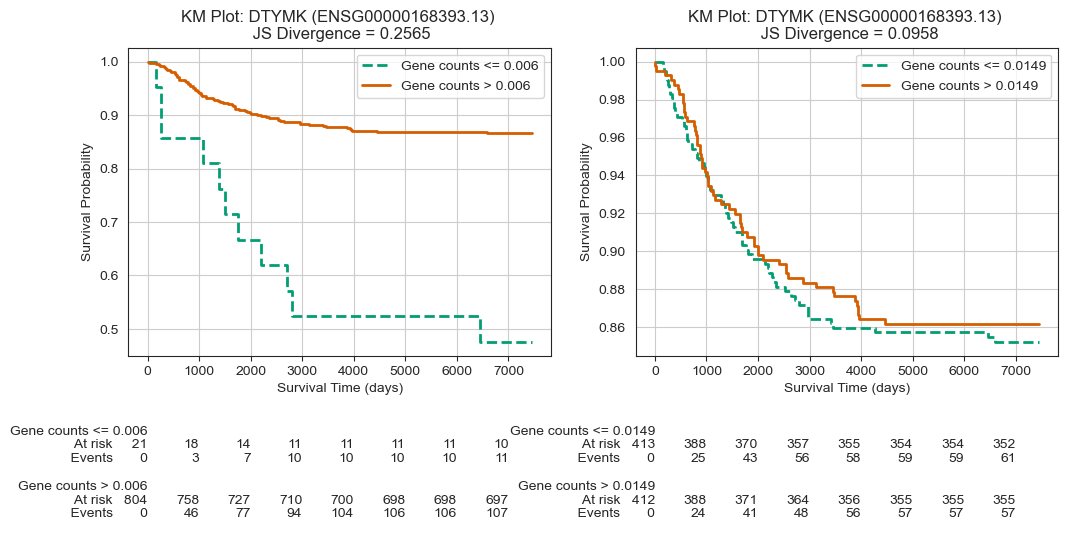

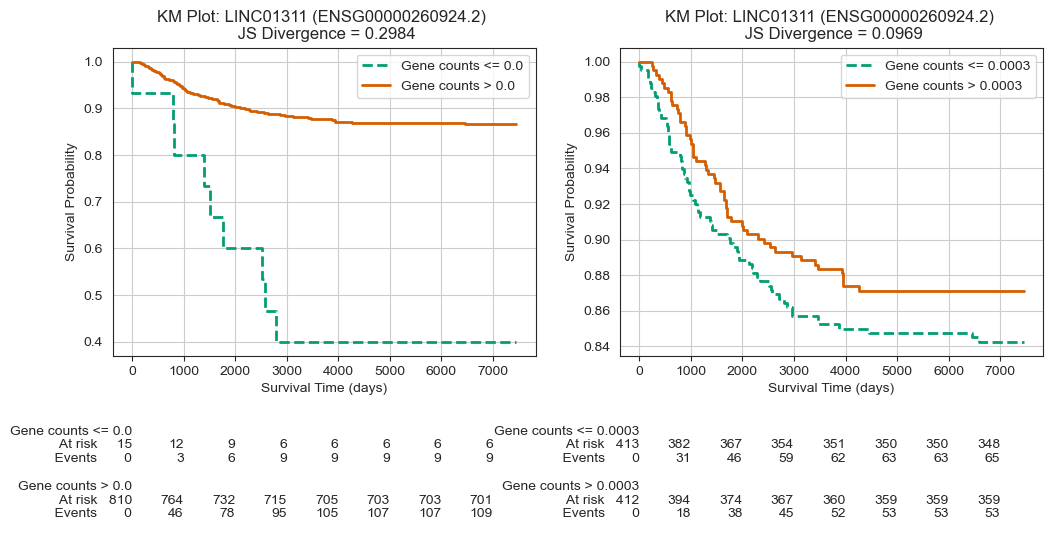

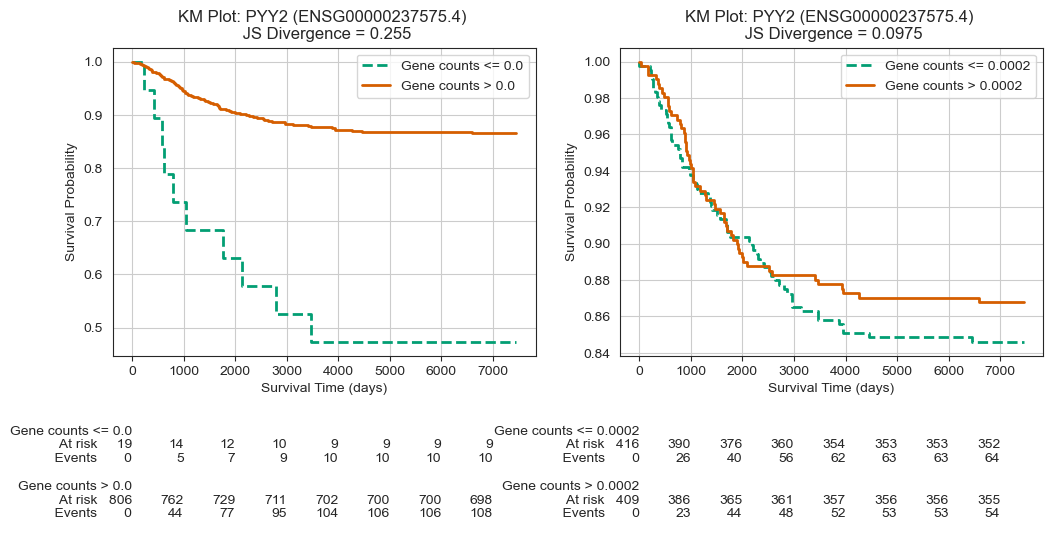

In [28]:
epsilon = 1e-10

# KM plot using optimal threshold VS median
for i, gene in enumerate(gene_list):

    # Get gene count of that gene
    row = pd.to_numeric(df_with_subtype.loc[gene].values, errors='coerce')

    # Get optimal threshold for that gene
    tbl = jsd_result[jsd_result['gene'] == gene]
    optimal_threshold = pd.to_numeric(tbl['threshold'].values[0], errors='coerce')

    # Extract days to death
    time_g1 = survival_time[row <= optimal_threshold]
    time_g2 = survival_time[row > optimal_threshold]
    
    # Extract status
    status_g1 = status[row <= optimal_threshold]
    status_g2 = status[row > optimal_threshold]

    data_g1 = pd.DataFrame({
        'survival_time': time_g1,
        'group': 'Low Expression',
        'event_occurred': status_g1})

    data_g2 = pd.DataFrame({
        'survival_time': time_g2,
        'group': 'HighExpression',
        'event_occurred': status_g2})

    data = pd.concat([data_g1, data_g2], axis=0, ignore_index=True)

    # Calculate JSD
    # Combine both time groups to get all unique time values
    all_times = set(time_g1).union(set(time_g2))
    
    # Calculate the probability distribution for each group
    p = pd.Series(time_g1).value_counts(normalize=True).reindex(all_times, fill_value=0)
    q = pd.Series(time_g2).value_counts(normalize=True).reindex(all_times, fill_value=0)
    p = np.clip(p, epsilon, None)
    q = np.clip(q, epsilon, None)
    
    # Compute the average distribution
    m = 0.5 * (p + q)
    
    # Calculate KL Divergences
    KL_P_M = np.sum(p * np.log(p / m))
    KL_Q_M = np.sum(q * np.log(q / m))
    
    # Calculate JS divergence
    JSD = 0.5 * (KL_P_M + KL_Q_M)
    text = f"JS Divergence = {JSD.round(4)}"

    # Fit KaplanMeierFitter
    kmf_1 = KaplanMeierFitter()
    kmf_2 = KaplanMeierFitter()
    kmf_1.fit(data_g1['survival_time'], data_g1['event_occurred'], label=f"Gene counts <= {round(optimal_threshold, 4)}")
    kmf_2.fit(data_g2['survival_time'], data_g2['event_occurred'], label=f"Gene counts > {round(optimal_threshold, 4)}")

    # Plot Kaplan-Meier survival functions
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))

    # Top subplot
    ax = axs[0]
    kmf_1.plot_survival_function(ax=ax, ci_show=False, linestyle='dashed', linewidth=2, color=sns.color_palette('colorblind')[2])
    kmf_2.plot_survival_function(ax=ax, ci_show=False, linestyle='solid', linewidth=2, color=sns.color_palette('colorblind')[3])
    add_at_risk_counts(kmf_1, kmf_2, ax=ax, rows_to_show=['At risk', 'Events'])

    ax.set_title(f"KM Plot: {gene_id_to_name.get(gene, gene)} ({gene}) \n {text}")
    ax.set_xlabel("Survival Time (days)")
    ax.set_ylabel("Survival Probability")
    ax.grid(True)
    ax.legend()

    # Find the median value
    median = np.median(row)

    # Extract days to death
    time_g1 = survival_time[row <= median]
    time_g2 = survival_time[row > median]
    
    # Extract status
    status_g1 = status[row <= median]
    status_g2 = status[row > median]

    data_g1 = pd.DataFrame({
        'survival_time': time_g1,
        'group': 'Low Expression',
        'event_occurred': status_g1})

    data_g2 = pd.DataFrame({
        'survival_time': time_g2,
        'group': 'HighExpression',
        'event_occurred': status_g2})

    data = pd.concat([data_g1, data_g2], axis=0, ignore_index=True)

    # Calculate JSD
    # Combine both time groups to get all unique time values
    all_times = set(time_g1).union(set(time_g2))
    
    # Calculate the probability distribution for each group
    p = pd.Series(time_g1).value_counts(normalize=True).reindex(all_times, fill_value=0)
    q = pd.Series(time_g2).value_counts(normalize=True).reindex(all_times, fill_value=0)
    p = np.clip(p, epsilon, None)
    q = np.clip(q, epsilon, None)
    
    # Compute the average distribution
    m = 0.5 * (p + q)
    
    # Calculate KL Divergences
    KL_P_M = np.sum(p * np.log(p / m))
    KL_Q_M = np.sum(q * np.log(q / m))
    
    # Calculate JS divergence
    JSD = 0.5 * (KL_P_M + KL_Q_M)
    text = f"JS Divergence = {JSD.round(4)}"

    # Fit KaplanMeierFitter
    kmf_1 = KaplanMeierFitter()
    kmf_2 = KaplanMeierFitter()
    kmf_1.fit(data_g1['survival_time'], data_g1['event_occurred'], label=f"Gene counts <= {round(median, 4)}")
    kmf_2.fit(data_g2['survival_time'], data_g2['event_occurred'], label=f"Gene counts > {round(median, 4)}")

    # Top subplot
    ax = axs[1]
    kmf_1.plot_survival_function(ax=ax, ci_show=False, linestyle='dashed', linewidth=2, color=sns.color_palette('colorblind')[2])
    kmf_2.plot_survival_function(ax=ax, ci_show=False, linestyle='solid', linewidth=2, color=sns.color_palette('colorblind')[3])
    add_at_risk_counts(kmf_1, kmf_2, ax=ax, rows_to_show=['At risk', 'Events'])

    ax.set_title(f"KM Plot: {gene_id_to_name.get(gene, gene)} ({gene}) \n {text}")
    ax.set_xlabel("Survival Time (days)")
    ax.set_ylabel("Survival Probability")
    ax.grid(True)
    ax.legend()

In [30]:
subtype = 'LumA'
ks_result = pd.read_csv(f'/Users/tk/Desktop/gene_project/result2/ks_{subtype}.csv', sep=',')

In [31]:
gene_list = ['ENSG00000186501.14'] # From venn diagram: LumA

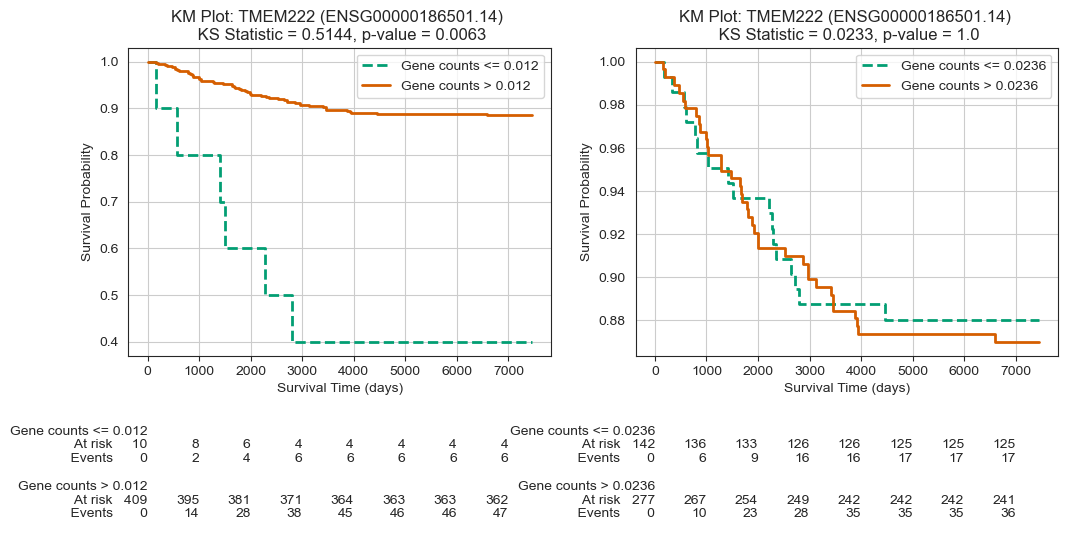

In [35]:
# KM plot using optimal threshold VS median
for i, gene in enumerate(gene_list):

    # Get gene count of that gene
    row = pd.to_numeric(df_with_subtype.loc[gene].values, errors='coerce')

    # Get optimal threshold for that gene
    tbl = ks_result[ks_result['gene'] == gene]
    optimal_threshold = pd.to_numeric(tbl[f'threshold_{subtype}'].values[0], errors='coerce')

    # Subtype masking
    mask = (subtypes == subtype)
    time = survival_time[mask]
    event = status[mask]
    count = row[mask]
    
    # Split time, status based on current threshold
    time_g1 = time[count <= optimal_threshold]
    time_g2 = time[count > optimal_threshold]
    status_g1 = event[count <= optimal_threshold]
    status_g2 = event[count > optimal_threshold]

    data_g1 = pd.DataFrame({
        'survival_time': time_g1,
        'group': 'Low Expression',
        'event_occurred': status_g1})

    data_g2 = pd.DataFrame({
        'survival_time': time_g2,
        'group': 'HighExpression',
        'event_occurred': status_g2})

    data = pd.concat([data_g1, data_g2], axis=0, ignore_index=True)

    # Calculate KS statistic
    ks_stat, ks_pval = ks_2samp(time_g1, time_g2)
    text = f"KS Statistic = {round(ks_stat, 4)}, p-value = {round(ks_pval, 4)}"

    # Fit KaplanMeierFitter
    kmf_1 = KaplanMeierFitter()
    kmf_2 = KaplanMeierFitter()
    kmf_1.fit(data_g1['survival_time'], data_g1['event_occurred'], label=f"Gene counts <= {round(optimal_threshold, 4)}")
    kmf_2.fit(data_g2['survival_time'], data_g2['event_occurred'], label=f"Gene counts > {round(optimal_threshold, 4)}")

    # Plot Kaplan-Meier survival functions
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))

    # Top subplot
    ax = axs[0]
    kmf_1.plot_survival_function(ax=ax, ci_show=False, linestyle='dashed', linewidth=2, color=sns.color_palette('colorblind')[2])
    kmf_2.plot_survival_function(ax=ax, ci_show=False, linestyle='solid', linewidth=2, color=sns.color_palette('colorblind')[3])
    add_at_risk_counts(kmf_1, kmf_2, ax=ax, rows_to_show=['At risk', 'Events'])

    ax.set_title(f"KM Plot: {gene_id_to_name.get(gene, gene)} ({gene}) \n {text}")
    ax.set_xlabel("Survival Time (days)")
    ax.set_ylabel("Survival Probability")
    ax.grid(True)
    ax.legend()

    # Find the median value
    median = np.median(row)

    # Split time, status based on current threshold
    time_g1 = time[count <= median]
    time_g2 = time[count > median]
    status_g1 = event[count <= median]
    status_g2 = event[count > median]

    data_g1 = pd.DataFrame({
        'survival_time': time_g1,
        'group': 'Low Expression',
        'event_occurred': status_g1})

    data_g2 = pd.DataFrame({
        'survival_time': time_g2,
        'group': 'HighExpression',
        'event_occurred': status_g2})

    data = pd.concat([data_g1, data_g2], axis=0, ignore_index=True)

    # Calculate KS statistic
    ks_stat, ks_pval = ks_2samp(time_g1, time_g2)
    text = f"KS Statistic = {round(ks_stat, 4)}, p-value = {round(ks_pval, 4)}"

    # Fit KaplanMeierFitter
    kmf_1 = KaplanMeierFitter()
    kmf_2 = KaplanMeierFitter()
    kmf_1.fit(data_g1['survival_time'], data_g1['event_occurred'], label=f"Gene counts <= {round(median, 4)}")
    kmf_2.fit(data_g2['survival_time'], data_g2['event_occurred'], label=f"Gene counts > {round(median, 4)}")

    # Top subplot
    ax = axs[1]
    kmf_1.plot_survival_function(ax=ax, ci_show=False, linestyle='dashed', linewidth=2, color=sns.color_palette('colorblind')[2])
    kmf_2.plot_survival_function(ax=ax, ci_show=False, linestyle='solid', linewidth=2, color=sns.color_palette('colorblind')[3])
    add_at_risk_counts(kmf_1, kmf_2, ax=ax, rows_to_show=['At risk', 'Events'])

    ax.set_title(f"KM Plot: {gene_id_to_name.get(gene, gene)} ({gene}) \n {text}")
    ax.set_xlabel("Survival Time (days)")
    ax.set_ylabel("Survival Probability")
    ax.grid(True)
    ax.legend()

In [37]:
jsd_result = pd.read_csv(f'/Users/tk/Desktop/gene_project/result3/jsd_{subtype}.csv', sep=',')

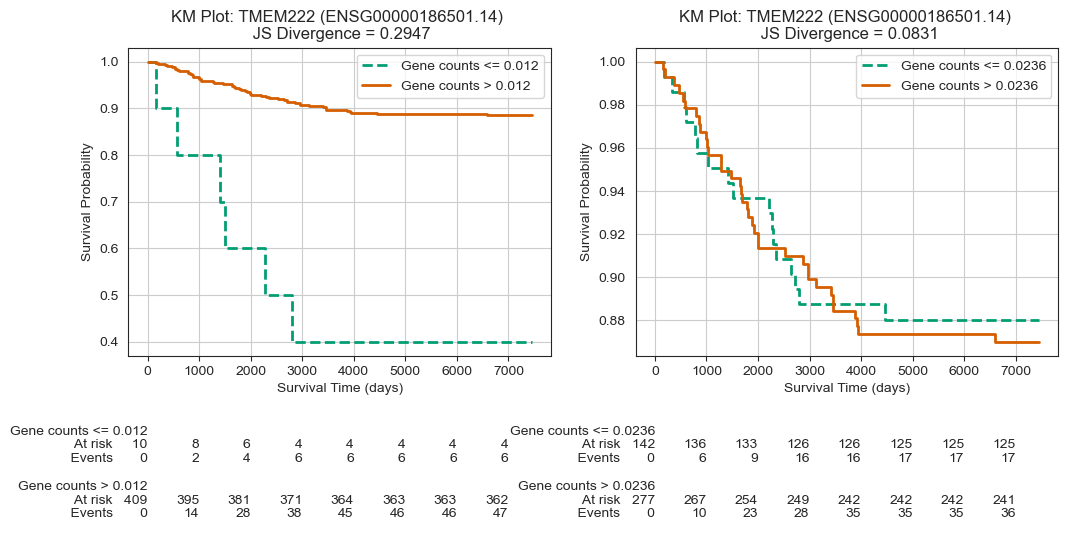

In [38]:
epsilon = 1e-10

# KM plot using optimal threshold VS median
for i, gene in enumerate(gene_list):

    # Get gene count of that gene
    row = pd.to_numeric(df_with_subtype.loc[gene].values, errors='coerce')

    # Get optimal threshold for that gene
    tbl = jsd_result[jsd_result['gene'] == gene]
    optimal_threshold = pd.to_numeric(tbl['threshold'].values[0], errors='coerce')

    # Subtype masking
    mask = (subtypes == subtype)
    time = survival_time[mask]
    event = status[mask]
    count = row[mask]
    
    # Split time, status based on current threshold
    time_g1 = time[count <= optimal_threshold]
    time_g2 = time[count > optimal_threshold]
    status_g1 = event[count <= optimal_threshold]
    status_g2 = event[count > optimal_threshold]

    data_g1 = pd.DataFrame({
        'survival_time': time_g1,
        'group': 'Low Expression',
        'event_occurred': status_g1})

    data_g2 = pd.DataFrame({
        'survival_time': time_g2,
        'group': 'HighExpression',
        'event_occurred': status_g2})

    data = pd.concat([data_g1, data_g2], axis=0, ignore_index=True)

    # Calculate JSD
    # Combine both time groups to get all unique time values
    all_times = set(time_g1).union(set(time_g2))
    
    # Calculate the probability distribution for each group
    p = pd.Series(time_g1).value_counts(normalize=True).reindex(all_times, fill_value=0)
    q = pd.Series(time_g2).value_counts(normalize=True).reindex(all_times, fill_value=0)
    p = np.clip(p, epsilon, None)
    q = np.clip(q, epsilon, None)
    
    # Compute the average distribution
    m = 0.5 * (p + q)
    
    # Calculate KL Divergences
    KL_P_M = np.sum(p * np.log(p / m))
    KL_Q_M = np.sum(q * np.log(q / m))
    
    # Calculate JS divergence
    JSD = 0.5 * (KL_P_M + KL_Q_M)
    text = f"JS Divergence = {JSD.round(4)}"

    # Fit KaplanMeierFitter
    kmf_1 = KaplanMeierFitter()
    kmf_2 = KaplanMeierFitter()
    kmf_1.fit(data_g1['survival_time'], data_g1['event_occurred'], label=f"Gene counts <= {round(optimal_threshold, 4)}")
    kmf_2.fit(data_g2['survival_time'], data_g2['event_occurred'], label=f"Gene counts > {round(optimal_threshold, 4)}")

    # Plot Kaplan-Meier survival functions
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))

    # Top subplot
    ax = axs[0]
    kmf_1.plot_survival_function(ax=ax, ci_show=False, linestyle='dashed', linewidth=2, color=sns.color_palette('colorblind')[2])
    kmf_2.plot_survival_function(ax=ax, ci_show=False, linestyle='solid', linewidth=2, color=sns.color_palette('colorblind')[3])
    add_at_risk_counts(kmf_1, kmf_2, ax=ax, rows_to_show=['At risk', 'Events'])

    ax.set_title(f"KM Plot: {gene_id_to_name.get(gene, gene)} ({gene}) \n {text}")
    ax.set_xlabel("Survival Time (days)")
    ax.set_ylabel("Survival Probability")
    ax.grid(True)
    ax.legend()

    # Find the median value
    median = np.median(row)

    # Split time, status based on current threshold
    time_g1 = time[count <= median]
    time_g2 = time[count > median]
    status_g1 = event[count <= median]
    status_g2 = event[count > median]

    data_g1 = pd.DataFrame({
        'survival_time': time_g1,
        'group': 'Low Expression',
        'event_occurred': status_g1})

    data_g2 = pd.DataFrame({
        'survival_time': time_g2,
        'group': 'HighExpression',
        'event_occurred': status_g2})

    data = pd.concat([data_g1, data_g2], axis=0, ignore_index=True)

    # Calculate JSD
    # Combine both time groups to get all unique time values
    all_times = set(time_g1).union(set(time_g2))
    
    # Calculate the probability distribution for each group
    p = pd.Series(time_g1).value_counts(normalize=True).reindex(all_times, fill_value=0)
    q = pd.Series(time_g2).value_counts(normalize=True).reindex(all_times, fill_value=0)
    p = np.clip(p, epsilon, None)
    q = np.clip(q, epsilon, None)
    
    # Compute the average distribution
    m = 0.5 * (p + q)
    
    # Calculate KL Divergences
    KL_P_M = np.sum(p * np.log(p / m))
    KL_Q_M = np.sum(q * np.log(q / m))
    
    # Calculate JS divergence
    JSD = 0.5 * (KL_P_M + KL_Q_M)
    text = f"JS Divergence = {JSD.round(4)}"

    # Fit KaplanMeierFitter
    kmf_1 = KaplanMeierFitter()
    kmf_2 = KaplanMeierFitter()
    kmf_1.fit(data_g1['survival_time'], data_g1['event_occurred'], label=f"Gene counts <= {round(median, 4)}")
    kmf_2.fit(data_g2['survival_time'], data_g2['event_occurred'], label=f"Gene counts > {round(median, 4)}")

    # Top subplot
    ax = axs[1]
    kmf_1.plot_survival_function(ax=ax, ci_show=False, linestyle='dashed', linewidth=2, color=sns.color_palette('colorblind')[2])
    kmf_2.plot_survival_function(ax=ax, ci_show=False, linestyle='solid', linewidth=2, color=sns.color_palette('colorblind')[3])
    add_at_risk_counts(kmf_1, kmf_2, ax=ax, rows_to_show=['At risk', 'Events'])

    ax.set_title(f"KM Plot: {gene_id_to_name.get(gene, gene)} ({gene}) \n {text}")
    ax.set_xlabel("Survival Time (days)")
    ax.set_ylabel("Survival Probability")
    ax.grid(True)
    ax.legend()